# How to use squapi executables
This nobebook explains the basic usage of squapi executables in the bin directory. 
There are four steps:
1. Load the squapi package
2. Set up a physical model
3. Set up squapi parameters
4. Run computations

Steps 1-3 use Python 3 only and step 4 uses squapi executable. 
All the math symbols and equation numbers used below are referring to those in Y. Sato *J. Chem Phys. 150 (2019) 224108*.

## 1. Load the squapi package 
The first step is to load the functions in squapi.py package located in the bin directory.

In [1]:
# First import essential packages:
import numpy as np
import subprocess
import sys
import matplotlib.pyplot as plt

# Then load squapi.py in the bin directory: 
sys.path.append('../bin/')
import squapi as sq

# For later use, we define some useful functions. 
# These are not essential, just for convenience.
def shell(cmd):
    '''
    Executes 'cmd' on shell and monitors the shell output real-time.
    '''
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    while True:
        output = process.stdout.readline().decode()
        if output == '' and process.poll() is not None:
            break
        if output:
            print(output.strip())

def graphics(Dt, Nmax, filename='rhos.dat'):
    '''
    Generates a population vs time plot from rhos.dat
    for a two-state model (state 1 and state 2)
    '''
    # extract rhos from rhos.dat:
    rhos = sq.load_rhos(filename)
    # Make a graph:
    times = np.array([k * Dt / fs for k in range(Nmax + 1)])
    plt.xlabel('Time (fs)')
    plt.ylabel('Population')
    plt.xlim(0, times[-1])
    plt.ylim(0, 1)
    plt.grid(b = True, which = 'both', color = '0.65',linestyle = '--')
    plt.plot(times, rhos[:, 0, 0].real, 'o-r', mfc='none', mec='r', label = r'$|1\rangle$')
    plt.plot(times, rhos[:, 1, 1].real, 'o-b', mfc='none', mec='b', label = r'$|2\rangle$')
    legend = plt.legend(loc='upper right', shadow=False, fontsize='large')
    plt.show()

## 2. Set up a physical model
The second step is to set up a moled, that is, to define the system Hamilonian $\hat{H}_0$, the bath temperature $T$, the bath function $g$, and so on. 
In the Python code below, variables are corresponding to physical quantities as follows:

| variable | quantity  | description |
|----------|:---------:|:------------|
| hbar     | $\hbar$   | the Planck constant |
| H0       | $\hat{H}_0$| system Hamiltonian (Eq.(1)) |
| T        | $T$ | bath temperature |
| s        | $\hat{s}_a$ | system-bath coupling operator (Eqs.(1) and (25)) |
| lam      | $\hbar\lambda$| reorganization energy (Eq.(3)) |
| mu       | $\hbar\mu$ | couter term (see Eqs.(1) and (9)) |
| g        | $g(t, T)$  | bath function (Eq.(7)) |
| rhos0    | $\rho_{\rm red}^{(0)}$ | initial reduced density matrix (Eq.(4)) |

The standard unit system that squapi uses is as follows:
- Time in pico-second (ps) = $10^{-12}$ sec
- Length in angstrom = $10^{-10}$ meter
- Energy in wavenumber (or reciprocal-centi-meter) $\displaystyle{\rm cm}^{-1} = \frac{hc}{1\,{\rm cm}} = 1.986\ 445\ 824\times 10^{-23}\,{\rm Joule}$ 

Some useful physical constants are written in squapi package and readily imported from it.

As a simple example, we consider an open quantum system of the total Hamiltonian $\hat{H}$ of Eq.(1) without the coutner term, $\mu = 0$, and the system of interest is a two-state system of states $|1\rangle$ and $|2\rangle$,
\begin{align}
    \hat{H}_0 = \epsilon_1 |1\rangle\langle 1| + \epsilon_2 |2\rangle\langle 2|
                + V(|1\rangle\langle 2| + |2\rangle\langle 1|) 
\end{align}
which is under the influence of a single bath with the system-bath coupling of 
\begin{align}
    \hat{s} = s_1 |1\rangle\langle 1| + s_2 |2 \rangle\langle 2|.
\end{align}
For the bath, we set the spectal density is of exponenital (see Eq.(A1) with $p=1$) with the cut-off frequency $\Omega$.


The variable s is an array containing all the information about the coupling operator $\hat{s}_a$ of Eq.(25), which is specified by the eigenvalues
\begin{align}
    \hat{s}_a\,|a,m\rangle = s_{am}\,|a, m\rangle.
\end{align}
for $a = 1, 2, \cdots, N_B$ with $N_B$ the number of baths, and $m = 1, 2, \cdots, M$ with $M$ the size of the system.
The array is formatted as follows: 
\begin{align}
   {\tt s} 
   = 
   \begin{bmatrix}
   \begin{bmatrix}s_{11},\ & s_{12},\ & \cdots\ \ & s_{1m},\  & \cdots\ \ & s_{1M}\end{bmatrix}\\
   \vdots \\
   \begin{bmatrix}s_{a1},\ & s_{a2},\ & \cdots\ \ & s_{am},\ & \cdots\ \ & s_{aM}\end{bmatrix}\\
   %\begin{bmatrix}\vdots & \vdots &        & \vdots &        & \vdots\end{bmatrix}\\
   \vdots \\
   \begin{bmatrix}s_{N_B\,1}, & s_{N_B\, 2}, & \cdots & s_{N_B\, m}, & \cdots & s_{N_B\,M}\end{bmatrix}\\
   \end{bmatrix}
\end{align}
For the two-state model, the size of state is $M=2$ and the number of bath is $N_B = 1$, so the s array is simply
\begin{align}
    {\tt s} 
    = 
    \begin{bmatrix} \begin{bmatrix}s_1 \ , & s_2\end{bmatrix} \end{bmatrix}.
\end{align}
Likewise, the matrix representation of $\hat{H}_0$ is
\begin{align}
    {\tt H0} 
    = 
    \begin{bmatrix}
    \begin{bmatrix}\epsilon_1\ , && V\end{bmatrix}\\
    \begin{bmatrix} V\ , && \epsilon_2\end{bmatrix}
    \end{bmatrix}.
\end{align}
For squapi computation below, we set the values $s_1 = -1/2$, $s_2 = 1/2$, $\epsilon_1 = 200\,{\rm cm}^{-1}$, $\epsilon_2 = 100\,{\rm cm}^{-1}$, $V = -100\,{\rm cm}^{-1}$.
Further more, we set the bath temperature $T = 77{\rm K}$, the cut-off frequency $\hbar\Omega = 50\,{\rm cm}^{-1}$ and the reorganization energy $\hbar\lambda = 30\,{\rm cm}^{-1}$.

In [2]:
# Load some useful pysical constants defined in quapi.py:
hbar    = sq.hbar    # The Planck cons in units of [cm^-1 * ps]
fs      = sq.fs      # 1 fs in units of [ps]

H0    = [[200, -100], [-100, 100]] # The matrix representation of the system Hamiltonian
T     = 77                         # Bath temperature in [K]
s     = [[-1/2, 1/2]]              # The s array (dimensionless)
lam   = [30]                       # Reorganization energies in [cm^-1]
mu    = [0]                        # The counter term in [cm^-1]
Omega = 50/hbar                    # The cut-off frequency in [1/ps]   
# In squapi, the bath function g MUST be defined as a function of
# two variables, 'bath' and 't'. Here 'bath' identifies the bath for 
# multi-bath model, which is found in benchmarks/benchmark1.py
# And 't' is the time in units of pico-second. Using the lambda
# expression, g is set as follows:
g = lambda bath, t: sq.gexp(t, lam[bath], Omega, T)

# Set up the initial density matirx. As an example, let the state |1> be excited:
rhos0 = [[1, 0],[0, 0]]

## 3. Set up squapi parameters

The essential squapi parameters are generated based on the two QuAPI parameters, $\varDelta t$ and $\varDelta k_{\rm max}$, the threshold $\vartheta$, and the model. In the Python code below, the variables involved are as follows:

| variable | quantity  | description |
|----------|:---------:|:------------|
| Dt       | $\varDelta t$| time slice in ps  |
| Dkmax    | $\varDelta k_{\rm max}$| max time steps for Non-Marcovianic memory |
| theta    | $\vartheta$ | cut-off of propagator (see description belwo Eq.(18)) |

In [3]:
# Set up the essential squapi paramters:
Dt      = 15 * fs # Dt must be positive [20 * fs]
Dkmax   = 9       # Dkmax must be positive integer (Dkmax > 0) [9] 
# Then generate system.dat from the model and the quapi parameters:
sq.save_system(H0, s, lam, mu, Dt, Dkmax, g)
# And generate init.dat from the initial density matrix:
sq.save_init(rhos0)

Generating system.dat
Generating init.dat


## 4. Run computations

Now we are ready to run a squapi executable. All the executables take the following inputs: 
- system.dat 
- init.dat 
- Nmax
- theta

The the output is the file containing the reduced density matrix $\rho_{\rm red}^{(N)}$ (see Eqs.(4) and (18)) for $N = 0, 1, 2, \cdots,$ Nmax: 
- rhos.dat

The basic syntax is as follows: 

```
$ (squapi executable) system.dat init.dat (Nmax) (theta)
```

Here, $ is the shell prompt, not a part of the command.

****************************************
*            squapi ver 0.0            *
****************************************
----- Date and Time --------------------
Sun Feb 14 16:01:10 EST 2021
----- parameters -----------------------
Dt     = 0.015 ps
Nmax   = 20
Dkmax  = 9
M      = 2
theta  = 0
----- generate Cn and Wn ---------------
size of C1 = 4
size of C2 = 16  lap time = 7.9e-05 sec
size of C3 = 64  lap time = 0.000112 sec
size of C4 = 256  lap time = 0.000268 sec
size of C5 = 1024  lap time = 0.001187 sec
size of C6 = 4096  lap time = 0.005334 sec
size of C7 = 16384  lap time = 0.024542 sec
size of C8 = 65536  lap time = 0.109334 sec
size of C9 = 262144  lap time = 0.474149 sec
----- generate Cnmap -------------------
lap time = 0.089361 sec
----- generate rhos --------------------
N = 0 of 20 lap time = 0.000479 sec tr = 1
N = 1 of 20 lap time = 0.000255 sec tr = 1
N = 2 of 20 lap time = 0.000294 sec tr = 1
N = 3 of 20 lap time = 0.00034 sec tr = 1
N = 4 of 20 lap time = 0.000

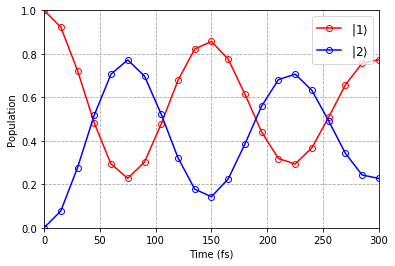

In [4]:
# Then compute the quantum dynamics with squapi (serial) executable in bin:
Nmax    = 20 # The maximum number of the time steps [20]
theta   = 0  # threshold [0]
cmd = '../bin/squapi system.dat init.dat ' + str(Nmax) + ' ' + str(theta)
shell(cmd)
# Make a plot based on the result:
graphics(Dt, Nmax)

****************************************
*         squapi_omp ver 0.0           *
****************************************
----- Date and Time --------------------
Sun Feb 14 16:01:42 EST 2021
----- parameters -----------------------
Dt     = 0.015 ps
Nmax   = 20
Dkmax  = 9
M      = 2
theta  = 0
----- generate Cn and Wn ---------------
size of C1 = 4
size of C2 = 16  lap time = 0.003718 sec
size of C3 = 64  lap time = 0.000478 sec
size of C4 = 256  lap time = 0.000985 sec
size of C5 = 1024  lap time = 0.005462 sec
size of C6 = 4096  lap time = 0.010799 sec
size of C7 = 16384  lap time = 0.043159 sec
size of C8 = 65536  lap time = 0.144454 sec
size of C9 = 262144  lap time = 0.508993 sec
----- generate Cnmap -------------------
lap time = 0.052576 sec
----- generate rhos --------------------
N = 0 of 20 lap time = 0.000503 sec tr = 1
N = 1 of 20 lap time = 0.000894 sec tr = 1
N = 2 of 20 lap time = 0.00027 sec tr = 1
N = 3 of 20 lap time = 0.000254 sec tr = 1
N = 4 of 20 lap time = 0.00

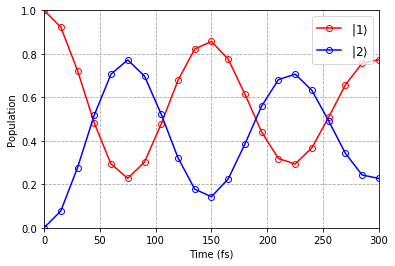

In [5]:
# Let's see how OpenMP improves the performance by
# runnin exactly the same computation with squapi_omp.
# NOTE: The option '--save' has been added to create the save point, 'D.dat'
#       This can be omitted here but needs for '--cont' explained below 
Nmax  = 20
theta = 0
cmd = '../bin/squapi_omp system.dat init.dat ' + str(Nmax) + ' ' + str(theta) + ' --save'
shell(cmd)
graphics(Dt, Nmax)

****************************************
*         squapi_omp ver 0.0           *
****************************************
----- Date and Time --------------------
Sun Feb 14 16:02:05 EST 2021
----- parameters -----------------------
Dt     = 0.015 ps
Nmax   = 40
Dkmax  = 9
M      = 2
theta  = 0
----- generate Cn and Wn ---------------
size of C1 = 4
size of C2 = 16  lap time = 0.000532 sec
size of C3 = 64  lap time = 0.000187 sec
size of C4 = 256  lap time = 0.000472 sec
size of C5 = 1024  lap time = 0.002049 sec
size of C6 = 4096  lap time = 0.006908 sec
size of C7 = 16384  lap time = 0.029921 sec
size of C8 = 65536  lap time = 0.13142 sec
size of C9 = 262144  lap time = 0.48711 sec
----- generate Cnmap -------------------
lap time = 0.076235 sec
----- generate rhos --------------------
N = 21 of 40 lap time = 1.04903 sec tr = 1
N = 22 of 40 lap time = 1.15213 sec tr = 1
N = 23 of 40 lap time = 1.14814 sec tr = 1
N = 24 of 40 lap time = 1.02672 sec tr = 1
N = 25 of 40 lap time = 1.02

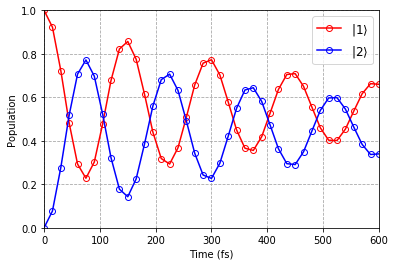

In [6]:
# The OpenMP version saves the D array in D.dat, if '--save' or '-s' option has
# been added, so you can continue the computation to any larger Nmax value 
# by adding "--cont" option at the end of squapi_omp arguments.
# NOTE: the theta value is also loaded from D.dat so any attempt to
#       change theta value here will be ignored.
# Let's do this up to Nmax = 40:
Nmax = 40
theta = 1e-5 # this will be ignored
cmd = '../bin/squapi_omp system.dat init.dat ' + str(Nmax) + ' ' + str(theta) + ' --cont'
shell(cmd)
graphics(Dt, Nmax)

****************************************
*         squapi_mpi ver 0.0           *
****************************************
----- Date and Time --------------------
Sun Feb 14 16:02:35 EST 2021
----- parameters -----------------------
Dt     = 0.015 ps
Nmax   = 20
Dkmax  = 9
M      = 2
theta  = 1e-06
nprocs = 2
----- generate Cn and Wn ---------------
size of C1 = 4
size of C2 = 16  lap time = 0.001498 sec
size of C3 = 64  lap time = 0.000378 sec
size of C4 = 256  lap time = 0.000356 sec
size of C5 = 1024  lap time = 0.001217 sec
size of C6 = 4096  lap time = 0.004137 sec
size of C7 = 16332  lap time = 0.013239 sec
size of C8 = 63656  lap time = 0.051063 sec
size of C9 = 234604  lap time = 0.209214 sec
----- generate Cnmap -------------------
lap time = 0.065815 sec
----- generate rhos --------------------
N = 0 of 20 lap time = 0.000466 sec tr = 1
* nrounds     = 1
* nrounds_reg = 1
* nranks_reg  = 2
* nranks_sem  = 0
* block_reg   = 2
* block_fin   = 0
N = 1 of 20 lap time = 0.002513 

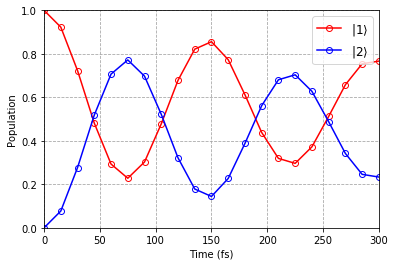

In [7]:
# Likewise, the exectable of the MPI version is squapi_mpi.
# This time, you have to use 'mpiexec'. 
# Let's do this for Nmax = 20 and set up some small nonzero
# theta. You see the trace is no longer 1 due to the 
# reduced number of propagators.
Nmax  = 20
theta = 1e-6 
cmd = 'mpiexec ../bin/squapi_mpi system.dat init.dat ' \
       + str(Nmax) + ' ' + str(theta) + ' -s'
shell(cmd)
graphics(Dt, Nmax)

****************************************
*         squapi_mpi ver 0.0           *
****************************************
----- Date and Time --------------------
Sun Feb 14 16:02:59 EST 2021
----- parameters -----------------------
Dt     = 0.015 ps
Nmax   = 40
Dkmax  = 9
M      = 2
theta  = 1e-06
nprocs = 2
----- generate Cn and Wn ---------------
size of C1 = 4
size of C2 = 16  lap time = 0.001256 sec
size of C3 = 64  lap time = 0.000895 sec
size of C4 = 256  lap time = 0.000389 sec
size of C5 = 1024  lap time = 0.000983 sec
size of C6 = 4096  lap time = 0.002877 sec
size of C7 = 16332  lap time = 0.009166 sec
size of C8 = 63656  lap time = 0.041411 sec
size of C9 = 234604  lap time = 0.185469 sec
----- generate Cnmap -------------------
lap time = 0.06454 sec
----- generate rhos --------------------
N = 21 of 40 lap time = 1.1592 sec tr = 0.99997
N = 22 of 40 lap time = 1.19825 sec tr = 0.999968
N = 23 of 40 lap time = 1.37014 sec tr = 0.999966
N = 24 of 40 lap time = 1.70182 sec 

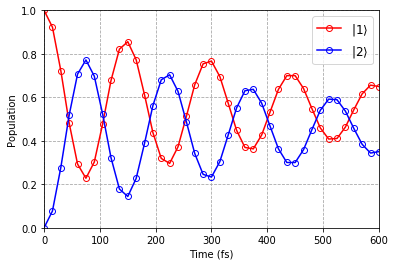

In [8]:
# And you can extend the computation, as you did with 
# the OpenMP version, to larger Nmax value by adding
# "--cont" or "-c" option.
# Let's do this up to Nmax = 40:
Nmax = 40
cmd = 'mpiexec ../bin/squapi_mpi system.dat init.dat ' \
       + str(Nmax) + ' ' + str(theta) + ' -c'
shell(cmd)
graphics(Dt, Nmax)